In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import cv2
import numpy as np
import os
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
import keras
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from google.colab.patches import cv2_imshow
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, MaxPool2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.initializers import glorot_uniform

In [ ]:
train_path = "/content/gdrive/MyDrive/ProjectDeliveries/faceMask_SocialDistance/data"
class_names = os.listdir(train_path)

In [ ]:
print(class_names)

['.DS_Store', 'without_mask', 'with_mask']


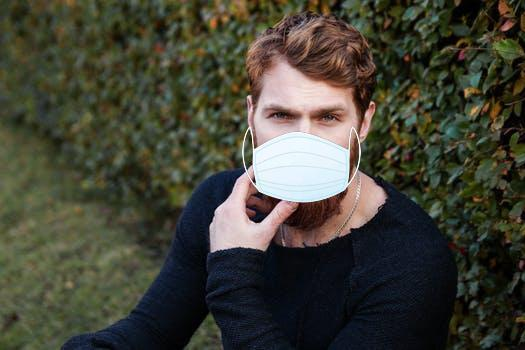

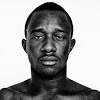

In [ ]:
# Sample datasets images
image_with_mask = cv2.imread(train_path + "/with_mask/with_mask_1.jpg")
cv2_imshow(image_with_mask)
image_without_mask = cv2.imread(train_path +
                                "/without_mask/without_mask_1.jpg")
cv2_imshow(image_without_mask)

In [ ]:
with_maskImage = os.listdir(train_path + "/with_mask")
without_maskImage = os.listdir(train_path + "/without_mask/")

In [ ]:
os.mkdir('/content/gdrive/MyDrive/ProjectDeliveries/faceMask_SocialDistance/train')
os.mkdir('/content/gdrive/MyDrive/ProjectDeliveries/faceMask_SocialDistance/train/without_mask')
os.mkdir('/content/gdrive/MyDrive/ProjectDeliveries/faceMask_SocialDistance/train/with_mask')

os.mkdir('/content/gdrive/MyDrive/ProjectDeliveries/faceMask_SocialDistance/test')
os.mkdir('/content/gdrive/MyDrive/ProjectDeliveries/faceMask_SocialDistance/test/with_mask')
os.mkdir('/content/gdrive/MyDrive/ProjectDeliveries/faceMask_SocialDistance/test/without_mask')

In [ ]:
with_mask_train_len = int(np.round(0.7 * len(with_maskImage), 0))

for i in range(with_mask_train_len):
    shutil.copy(
        os.path.join(train_path + "/with_mask", with_maskImage[i]),
        '/content/gdrive/MyDrive/ProjectDeliveries/faceMask_SocialDistance/train/with_mask')

for i in range(with_mask_train_len, len(with_maskImage)):
    shutil.copy(
        os.path.join(train_path + "/with_mask/", with_maskImage[i]),
        '/content/gdrive/MyDrive/ProjectDeliveries/faceMask_SocialDistance/test/with_mask')

without_mask_train_len = int(np.round(0.6 * len(without_maskImage), 0))
without_mask_val_len = int(np.round(0.7 * len(without_maskImage), 0))

for i in range(without_mask_train_len):
    shutil.copy(
        os.path.join(train_path + "/without_mask", without_maskImage[i]),
        '/content/gdrive/MyDrive/ProjectDeliveries/faceMask_SocialDistance/train/without_mask')

for i in range(with_mask_train_len, len(without_maskImage)):
    shutil.copy(
        os.path.join(train_path + "/without_mask", without_maskImage[i]),
        '/content/gdrive/MyDrive/ProjectDeliveries/faceMask_SocialDistance/test/without_mask')

In [ ]:
train_datagen = ImageDataGenerator(zoom_range=0.15,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.15)
test_datagen = ImageDataGenerator()

In [ ]:
train_generator = train_datagen.flow_from_directory(
    "/content/gdrive/MyDrive/ProjectDeliveries/faceMask_SocialDistance/train",
    target_size=(224, 224),
    batch_size=32,
    shuffle=True,
    class_mode='binary')
test_generator = test_datagen.flow_from_directory(
    "/content/gdrive/MyDrive/ProjectDeliveries/faceMask_SocialDistance/test",
    target_size=(224, 224),
    batch_size=32,
    shuffle=False,
    class_mode='binary')

Found 4905 images belonging to 2 classes.
Found 2337 images belonging to 2 classes.


In [ ]:
def identity_block(X, f, filters, stage, block):

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1,
               kernel_size=(1, 1),
               strides=(1, 1),
               padding='valid',
               name=conv_name_base + '2a',
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2,
               kernel_size=(f, f),
               strides=(1, 1),
               padding='same',
               name=conv_name_base + '2b',
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3,
               kernel_size=(1, 1),
               strides=(1, 1),
               padding='valid',
               name=conv_name_base + '2c',
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X = Add()([X, X_shortcut])  # SKIP Connection
    X = Activation('relu')(X)

    return X

In [ ]:
def convolutional_block(X, f, filters, stage, block, s=2):

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1,
               kernel_size=(1, 1),
               strides=(s, s),
               padding='valid',
               name=conv_name_base + '2a',
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2,
               kernel_size=(f, f),
               strides=(1, 1),
               padding='same',
               name=conv_name_base + '2b',
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3,
               kernel_size=(1, 1),
               strides=(1, 1),
               padding='valid',
               name=conv_name_base + '2c',
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X_shortcut = Conv2D(filters=F3,
                        kernel_size=(1, 1),
                        strides=(s, s),
                        padding='valid',
                        name=conv_name_base + '1',
                        kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3,
                                    name=bn_name_base + '1')(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [ ]:
def ResNet50(input_shape=(224, 224, 3)):

    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)

    X = Conv2D(64, (7, 7),
               strides=(2, 2),
               name='conv1',
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X,
                            f=3,
                            filters=[64, 64, 256],
                            stage=2,
                            block='a',
                            s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    X = convolutional_block(X,
                            f=3,
                            filters=[128, 128, 512],
                            stage=3,
                            block='a',
                            s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    X = convolutional_block(X,
                            f=3,
                            filters=[256, 256, 1024],
                            stage=4,
                            block='a',
                            s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    X = X = convolutional_block(X,
                                f=3,
                                filters=[512, 512, 2048],
                                stage=5,
                                block='a',
                                s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)

    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    return model

In [ ]:
base_model = ResNet50(input_shape=(224, 224, 3))

In [ ]:
headModel = base_model.output
headModel = Flatten()(headModel)
headModel = Dense(256,
                  activation='relu',
                  name='fc1',
                  kernel_initializer=glorot_uniform(seed=0))(headModel)
headModel = Dense(128,
                  activation='relu',
                  name='fc2',
                  kernel_initializer=glorot_uniform(seed=0))(headModel)
headModel = Dense(1,
                  activation='sigmoid',
                  name='fc3',
                  kernel_initializer=glorot_uniform(seed=0))(headModel)

In [ ]:
model = Model(inputs=base_model.input, outputs=headModel)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 64  9472        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [ ]:
base_model.load_weights(
    "/content/gdrive/MyDrive/ProjectDeliveries/faceMask_SocialDistance/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5")

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
optimizer = SGD(clipvalue=0.5)

model.compile(loss="binary_crossentropy",
              optimizer=optimizer, metrics=["accuracy"])

In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5)

In [ ]:
mc = ModelCheckpoint('/content/gdrive/MyDrive/ProjectDeliveries/faceMask_SocialDistance/best_model.h5',
                     monitor='val_accuracy', mode='max', verbose=1, patience=5)

In [ ]:
H = model.fit_generator(train_generator, validation_data=test_generator,
                        epochs=30, verbose=1, callbacks=[mc, es])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/30
 37/154 [======>.......................] - ETA: 1:17 - loss: 0.2782 - accuracy: 0.9020

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


154/154 [==============================] - ETA: 0s - loss: 0.1232 - accuracy: 0.9545
Epoch 1: saving model to /content/gdrive/MyDrive/ProjectDeliveries/Rohit/best_model.h5
154/154 [==============================] - 120s 781ms/step - loss: 0.1232 - accuracy: 0.9545 - val_loss: 0.0723 - val_accuracy: 0.9760
Epoch 2/30
154/154 [==============================] - ETA: 0s - loss: 0.0489 - accuracy: 0.9833
Epoch 2: saving model to /content/gdrive/MyDrive/ProjectDeliveries/Rohit/best_model.h5
154/154 [==============================] - 118s 764ms/step - loss: 0.0489 - accuracy: 0.9833 - val_loss: 0.0445 - val_accuracy: 0.9842
Epoch 3/30
154/154 [==============================] - ETA: 0s - loss: 0.0335 - accuracy: 0.9896
Epoch 3: saving model to /content/gdrive/MyDrive/ProjectDeliveries/Rohit/best_model.h5
154/154 [==============================] - 117s 762ms/step - loss: 0.0335 - accuracy: 0.9896 - val_loss: 0.0381 - val_accuracy: 0.9872
Epoch 4/30
154/154 [==============================] - ETA

In [ ]:
model.load_weights(
    "/content/gdrive/MyDrive/ProjectDeliveries/faceMask_SocialDistance/best_model.h5")

In [ ]:
score = model.evaluate_generator(test_generator)
print("Accuracy Score :", score[1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


Accuracy Score : 0.9901583194732666


In [ ]:
model.save("/content/gdrive/MyDrive/ProjectDeliveries/faceMask_SocialDistance/FaceMaskModel.model")

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/ProjectDeliveries/Rohit/FaceMaskModel.model/assets


In [ ]:
image_path = "/content/gdrive/MyDrive/ProjectDeliveries/faceMask_SocialDistance/data/with_mask/with_mask_2.jpg"

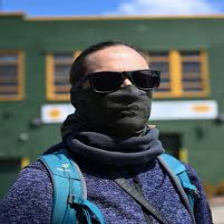

Predicted Label: Mask Detected


In [ ]:
image = cv2.imread(image_path)
image = cv2.resize(image, (224, 224))
cv2_imshow(image)
preds = model.predict(np.expand_dims(image, axis=0))[0]
if round(preds[0]) == 0:
    print("Predicted Label: Mask Detected")
else:
    print("Predicted Label: NO MasK")